In [ ]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
# from project_lib import Project
# project = Project(project_id='b6448912-02d6-4490-b68b-99cf2710be0c', project_access_token='p-3d73999943b69f295899a7bab545831f9cef4f9d')
# pc = project.project_context
# claves para ibm cloud, debe cambiarse por el propio 

# MARATONA BEHIND THE CODE 2020

## DESAFIO 4 - CompuSoluciones

### Introducción

En este desafío, CompuSoluciones usará herramientas de IBM como Watson Studio (o Cloud Pack for Data) y Watson Machine Learning para construir un modelo de Machine Learning natural capaz de predecir la probabilidad de cumplimiento de pago.

La idea esencial del Desafío 4 es crear un modelo basado en machine learning capaz de identificar el comportamiento financiero del asociado de negocio, permitiendo una probabilidad de cumplimiento o incumplimiento del crédito.

<hr>

### Instalación de Librerias

In [ ]:
!pip install scikit-learn==0.20.4 --upgrade

Requirement already up-to-date: scikit-learn==0.20.4 in /opt/conda/envs/Python36/lib/python3.6/site-packages (0.20.4)


In [ ]:
# Si desea utilizar la biblioteca ** xgboost **, instale la versión 0.71.
#!pip install xgboost==0.71 --upgrade

In [ ]:
import json
import requests
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

### Descargando el dataset csv desde Github

In [ ]:
!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/vanderlei-test/dataset/master/reto-4-compu-train.csv

--2020-09-07 01:05:30--  https://raw.githubusercontent.com/vanderlei-test/dataset/master/reto-4-compu-train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1751735 (1.7M) [text/plain]
Saving to: ‘reto-4-compu-train.csv.7’

100%[======================================>] 1,751,735   --.-K/s   in 0.04s   

2020-09-07 01:05:30 (46.5 MB/s) - ‘reto-4-compu-train.csv.7’ saved [1751735/1751735]



In [ ]:
df = pd.read_csv(r'reto-4-compu-train.csv')
df.head()

,EFECTIVO,CXC,INVENTARIO,EQ_OFICINA,EQ_TRANSPORTE,TERRENOS_Y_CONSTRUCCIONES,CXP,CONTRIBUCIONES_X_PAGAR,ANTICIPOS_CTE,CAP_SOCIAL,UTILIDADES_ACUMULADAS,UTILIDAD_O_PERDIDA,TOTAL_VENTAS,TOTAL_COMPRAS,UTILIDAD_BRUTA,TOTAL_GASTOS,OBJETIVO
0,NaN,7.710800e+06,NaN,1.237449e+06,2.947057e+05,8.812520e+06,4.547214e+07,239671.50090,1.257907e+06,2356497.733,-6.009930e+06,-6.816681e+06,41309820.53,6.872572e+07,6298390.104,1.505762e+07,Aceptado
1,7.437098e+04,2.213116e+06,NaN,1.335531e+05,4.000109e+05,8.491851e+06,1.573254e+07,94809.20697,6.708985e+05,NaN,-7.980962e+06,-3.342452e+06,NaN,3.588274e+07,NaN,1.085156e+07,Aceptado
2,5.269987e+06,2.893119e+07,3.983352e+05,1.533061e+07,3.478673e+06,-1.393229e+07,NaN,610814.63990,1.009937e+07,1444426.243,NaN,-4.026344e+06,NaN,3.292337e+08,NaN,8.680735e+06,Sospechoso
3,9.092134e+05,1.145092e+07,9.577823e+06,1.068692e+06,1.302021e+06,1.379064e+06,NaN,NaN,2.378928e+06,1236065.779,NaN,-4.567435e+06,76310275.60,NaN,NaN,1.323267e+07,Aceptado
4,9.688669e+05,8.539206e+06,3.898283e+06,4.168733e+05,NaN,-6.297179e+05,7.620711e+06,116647.73960,1.798065e+06,3657339.603,7.702845e+05,-7.110320e+05,62901614.29,3.614260e+07,6850340.403,1.100048e+07,Aceptado


### Acerca del Dataset

In [ ]:
df

,EFECTIVO,CXC,INVENTARIO,EQ_OFICINA,EQ_TRANSPORTE,TERRENOS_Y_CONSTRUCCIONES,CXP,CONTRIBUCIONES_X_PAGAR,ANTICIPOS_CTE,CAP_SOCIAL,UTILIDADES_ACUMULADAS,UTILIDAD_O_PERDIDA,TOTAL_VENTAS,TOTAL_COMPRAS,UTILIDAD_BRUTA,TOTAL_GASTOS,OBJETIVO
0,NaN,7.710800e+06,NaN,1.237449e+06,2.947057e+05,8.812520e+06,4.547214e+07,2.396715e+05,1.257907e+06,2.356498e+06,-6.009930e+06,-6.816681e+06,4.130982e+07,6.872572e+07,6.298390e+06,1.505762e+07,Aceptado
1,7.437098e+04,2.213116e+06,NaN,1.335531e+05,4.000109e+05,8.491851e+06,1.573254e+07,9.480921e+04,6.708985e+05,NaN,-7.980962e+06,-3.342452e+06,NaN,3.588274e+07,NaN,1.085156e+07,Aceptado
2,5.269987e+06,2.893119e+07,3.983352e+05,1.533061e+07,3.478673e+06,-1.393229e+07,NaN,6.108146e+05,1.009937e+07,1.444426e+06,NaN,-4.026344e+06,NaN,3.292337e+08,NaN,8.680735e+06,Sospechoso
3,9.092134e+05,1.145092e+07,9.577823e+06,1.068692e+06,1.302021e+06,1.379064e+06,NaN,NaN,2.378928e+06,1.236066e+06,NaN,-4.567435e+06,7.631028e+07,NaN,NaN,1.323267e+07,Aceptado
4,9.688669e+05,8.539206e+06,3.898283e+06,4.168733e+05,NaN,-6.297179e+05,7.620711e+06,1.166477e+05,1.798065e+06,3.657340e+06,7.702845e+05,-7.110320e+05,6.290161e+07,3.614260e+07,6.850340e+06,1.100048e+07,Aceptado
5,1.773585e+06,NaN,6.114229e+07,7.232788e+05,1.027127e+06,4.234020e+06,9.704791e+07,7.831397e+05,2.590328e+06,7.179441e+06,1.868965e+07,-2.969676e+06,3.962079e+08,2.172557e+08,5.857123e+07,5.852510e+07,Aceptado
6,NaN,NaN,2.088920e+05,9.368770e+06,1.334774e+06,-8.602278e+06,8.468829e+06,2.531678e+05,4.966998e+06,5.281061e+05,6.189959e+06,-3.242946e+06,3.997930e+07,3.588782e+07,2.835826e+06,3.404083e+06,Sospechoso
7,2.012122e+06,4.499451e+07,3.629695e+07,1.383551e+07,NaN,6.183588e+06,9.058515e+07,3.228281e+06,9.338428e+06,8.995961e+06,1.326990e+07,NaN,2.083611e+08,1.272939e+08,4.596563e+07,3.582635e+07,Aceptado
8,2.083013e+06,5.642930e+06,4.777793e+05,1.029409e+06,4.285786e+05,-4.593901e+06,6.333387e+06,NaN,1.199690e+06,1.093923e+07,-4.110542e+06,4.717089e+05,1.151403e+07,1.480100e+07,6.585251e+06,1.457357e+07,Aceptado
9,8.946773e+05,5.463206e+07,NaN,1.278504e+07,3.773400e+06,3.124557e+06,8.545569e+07,1.956563e+05,2.055115e+06,1.329430e+05,1.920409e+07,-2.650301e+06,4.692272e+08,2.357381e+08,5.185442e+07,4.155025e+07,Aceptado


Las variables son todas numericas. Solo nuestra variable TARGET (Prestamo aprobado o posible incumplimiento financiero) es the tipo float.

La función describe() de abajo muestra varias estadisticas del dataset.

In [ ]:
from scipy.stats import chi2_contingency
chi2_contingency(pd.crosstab(df['TOTAL_GASTOS'], df['OBJETIVO']))

(7943.0, 0.4947246107103261, 7942, array([[0.94422762, 0.05577238],
        [0.94422762, 0.05577238],
        [0.94422762, 0.05577238],
        ...,
        [0.94422762, 0.05577238],
        [0.94422762, 0.05577238],
        [0.94422762, 0.05577238]]))

In [ ]:
from scipy.stats import linregress

linregress(df['TOTAL_GASTOS'], df['EFECTIVO'])

LinregressResult(slope=nan, intercept=nan, rvalue=nan, pvalue=nan, stderr=nan)

<hr>

### Entrenamiento y evaluación de un modelo de clasificación binaria


#### Transformación 1: excluir columnas del conjunto de datos

Para la creación de una transformación de datos personalizada en scikit-learn, es necesario crear una clase con los métodos transform y fit. En el método de 'transform', se ejecutará la lógica de nuestra transformación.

La siguiente celda muestra el código completo de una transformación DropColumns para eliminar columnas de un pandas DataFrame.


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin


# All sklearn Transforms must have the `transform` and `fit` methods
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Primero copiamos el dataframe de datos de entrada 'X'
        data = X.copy()
        # Devolvemos un nuevo dataframe de datos sin las columnas no deseadas
        return data.drop(labels=self.columns, axis='columns')

In [ ]:
# Creación de instancias de una transformación DropColumns
rm_columns = DropColumns(
    columns=
    
    
    [ 'CXC','EQ_OFICINA','EQ_TRANSPORTE' , 'CXP', 'CONTRIBUCIONES_X_PAGAR', 'CAP_SOCIAL' , 'TOTAL_COMPRAS', 'TOTAL_GASTOS'  ]  # Esta transformación toma como parámetro una lista con los nombres de las columnas no deseadas
)

print(rm_columns)

DropColumns(columns=['CXC', 'EQ_OFICINA', 'EQ_TRANSPORTE', 'CXP', 'CONTRIBUCIONES_X_PAGAR', 'CAP_SOCIAL', 'TOTAL_COMPRAS', 'TOTAL_GASTOS'])


In [ ]:
# Ver las columnas del conjunto de datos original
print("Columnas del conjunto de datos original: \n")
print(df.columns)

# Aplicar la transformación ``DropColumns`` al conjunto de datos base
rm_columns.fit(X=df)

# Reconstruyendo un DataFrame de Pandas con el resultado de la transformación
df2 = pd.DataFrame.from_records(
    data=rm_columns.transform(
        X=df
    ),
)

# Ver las columnas del conjunto de datos transformado
print("\n\nColumnas del conjunto de datos después de la transformación ``DropColumns``: \n")
print(df2.columns)

Columnas del conjunto de datos original: 

Index(['EFECTIVO', 'CXC', 'INVENTARIO', 'EQ_OFICINA', 'EQ_TRANSPORTE',
       'TERRENOS_Y_CONSTRUCCIONES', 'CXP', 'CONTRIBUCIONES_X_PAGAR',
       'ANTICIPOS_CTE', 'CAP_SOCIAL', 'UTILIDADES_ACUMULADAS',
       'UTILIDAD_O_PERDIDA', 'TOTAL_VENTAS', 'TOTAL_COMPRAS', 'UTILIDAD_BRUTA',
       'TOTAL_GASTOS', 'OBJETIVO'],
      dtype='object')


Columnas del conjunto de datos después de la transformación ``DropColumns``: 

Index(['EFECTIVO', 'INVENTARIO', 'TERRENOS_Y_CONSTRUCCIONES', 'ANTICIPOS_CTE',
       'UTILIDADES_ACUMULADAS', 'UTILIDAD_O_PERDIDA', 'TOTAL_VENTAS',
       'UTILIDAD_BRUTA', 'OBJETIVO'],
      dtype='object')


#### Transformación 2: estandarización de Features

In [ ]:
# # Crear un objeto ``SimpleImputer``
si = SimpleImputer(
    missing_values=np.nan,  # los valores que faltan son del tipo ``np.nan`` (Pandas estándar)
    strategy='mean',  # la estrategia elegida es cambiar el valor faltante por una constante
#     fill_value=0,  # la constante que se usará para completar los valores faltantes es un int64 = 0
    verbose=0,
    copy=True
)



In [ ]:
# Ver los datos faltantes del conjunto de datos antes de la primera transformación (df_data_2)
print("Valores nulos antes de la transformación SimpleImputer: \n\n{}\n".format(df2.isnull().sum(axis = 0)))


# Aplicamos el SimpleImputer ``si`` al conjunto de datos df_data_2 (resultado de la primera transformación)
si.fit(X=df2[
    [
        
       
        'EFECTIVO',
        'INVENTARIO',
        'TERRENOS_Y_CONSTRUCCIONES',
        'ANTICIPOS_CTE',
        'UTILIDADES_ACUMULADAS',
        'UTILIDAD_O_PERDIDA',
        'TOTAL_VENTAS',
        'UTILIDAD_BRUTA',
    ]
])
df2[[   'EFECTIVO',
        'INVENTARIO',
        'TERRENOS_Y_CONSTRUCCIONES',
        'ANTICIPOS_CTE',
        'UTILIDADES_ACUMULADAS',
        'UTILIDAD_O_PERDIDA',
        'TOTAL_VENTAS',
        'UTILIDAD_BRUTA',
]]=si.transform(
        X=df2[[
        'EFECTIVO',
        'INVENTARIO',
        'TERRENOS_Y_CONSTRUCCIONES',
        'ANTICIPOS_CTE',
        'UTILIDADES_ACUMULADAS',
        'UTILIDAD_O_PERDIDA',
        'TOTAL_VENTAS',
        'UTILIDAD_BRUTA',]])
# Reconstrucción de un nuevo DataFrame de Pandas con el conjunto imputado (df_data_3)
df3 = pd.DataFrame.from_records(
    data=df2,  # el resultado SimpleImputer.transform (<< pandas dataframe >>) es lista lista
    columns=df2.columns  # las columnas originales deben conservarse en esta transformación
)

# Ver los datos faltantes del conjunto de datos después de la segunda transformación (SimpleImputer) (df_data_3)
print("\n\nValores nulos en el conjunto de datos después de la transformación SimpleImputer: \n\n{}\n".format(df3.isnull().sum(axis = 0)))

Valores nulos antes de la transformación SimpleImputer: 

EFECTIVO                     1414
INVENTARIO                   1400
TERRENOS_Y_CONSTRUCCIONES    1362
ANTICIPOS_CTE                1424
UTILIDADES_ACUMULADAS        1407
UTILIDAD_O_PERDIDA           1369
TOTAL_VENTAS                 1459
UTILIDAD_BRUTA               1429
OBJETIVO                        0
dtype: int64



Valores nulos en el conjunto de datos después de la transformación SimpleImputer: 

EFECTIVO                     0
INVENTARIO                   0
TERRENOS_Y_CONSTRUCCIONES    0
ANTICIPOS_CTE                0
UTILIDADES_ACUMULADAS        0
UTILIDAD_O_PERDIDA           0
TOTAL_VENTAS                 0
UTILIDAD_BRUTA               0
OBJETIVO                     0
dtype: int64



In [ ]:
def pierde_gana (row):
    return (row['EFECTIVO']+row['INVENTARIO']+row['TERRENOS_Y_CONSTRUCCIONES']+row['ANTICIPOS_CTE']+row['UTILIDADES_ACUMULADAS']+row['UTILIDAD_O_PERDIDA']+row['TOTAL_VENTAS']+row['UTILIDAD_BRUTA'])

In [ ]:
def pierde_gana_acumulado (row):
   if row['UTILIDADES_ACUMULADAS'] > 0:
      return 1
   else:
      return 0

In [ ]:
datosReales = df3

In [ ]:

from sklearn.utils import resample

dfAprobados = df3[df3.OBJETIVO=='Aceptado']
dfNoAprobados= df3[df3.OBJETIVO=='Sospechoso']

df_minority_upsampled = resample(dfNoAprobados, 
                                 replace=True,     # sample with replacement
                                 n_samples=8000 ,    # to match majority class
                                 ) # reproducible results
df_mayority_upsampled = resample(dfAprobados, 
                                 replace=True,     # sample with replacement
                                 n_samples=2000 ,    # to match majority class
                                 ) 
df3 = pd.concat([df3, df_minority_upsampled])
datosAlRevez = pd.concat([df_minority_upsampled, df_mayority_upsampled])

In [ ]:

features = df3[
    [
        
       
        'EFECTIVO',
        
        'INVENTARIO',
       
        'TERRENOS_Y_CONSTRUCCIONES',
       
        'ANTICIPOS_CTE',
        
        'UTILIDADES_ACUMULADAS',
        'UTILIDAD_O_PERDIDA',
        'TOTAL_VENTAS',
        
        'UTILIDAD_BRUTA',
    ]
]
target = df3["OBJETIVO"] 




features2 = datosReales[
     [
        
       
        'EFECTIVO',
        
        'INVENTARIO',
       
        'TERRENOS_Y_CONSTRUCCIONES',
       
        'ANTICIPOS_CTE',
        
        'UTILIDADES_ACUMULADAS',
        'UTILIDAD_O_PERDIDA',
        'TOTAL_VENTAS',
        
        'UTILIDAD_BRUTA',

    ]
]
target2 = datosReales["OBJETIVO"]


features3 = datosAlRevez[
     [
        
       
        'EFECTIVO',
        
        'INVENTARIO',
       
        'TERRENOS_Y_CONSTRUCCIONES',
       
        'ANTICIPOS_CTE',
        
        'UTILIDADES_ACUMULADAS',
        'UTILIDAD_O_PERDIDA',
        'TOTAL_VENTAS',
        
        'UTILIDAD_BRUTA',

    ]
]
target3 = datosAlRevez["OBJETIVO"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=None)



X_train2, X_test2, y_train2, y_test2 = train_test_split(features2, target2, test_size=0.2, random_state=None)


X_train3, X_test3, y_train3, y_test3 = train_test_split(features3, target3, test_size=0.2, random_state=None)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
sc =MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_train2 = sc.fit_transform(X_train2)
X_test2 = sc.transform(X_test2)
X_train3 = sc.fit_transform(X_train3)
X_test3 = sc.transform(X_test3)

#### Entrenando un modelo ``DecisionTreeClassifier()``

In [ ]:
# Método para creacion de modelos basados en arbol de desición
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier
dtc=KNeighborsClassifier(n_neighbors=1)
model = dtc.fit(X_train, y_train)

In [ ]:
X_train.shape

(13920, 8)

In [ ]:
# from sklearn.feature_selection import SelectFromModel


# esto permite seleccionar las columnas mas importantes para nuestra prediccion, en este caso lo comento porque ya no es necesario

# modelSelective = SelectFromModel(dtc, prefit=True,threshold=0.02)
# X_train = modelSelective.transform(X_train)
# X_train.shape


# X_test = modelSelective.transform(X_test)
# X_test.shape

In [ ]:
#  model = dtc.fit(X_train, y_train)

#### Haciendo una predicción con el set de prueba

In [ ]:
y_pred = dtc.predict(X_test)
print(y_pred)

['Aceptado' 'Sospechoso' 'Aceptado' ... 'Sospechoso' 'Aceptado' 'Aceptado']


In [ ]:
y_pred.shape

(3480,)

In [ ]:
 y_test.shape

(3480,)

In [ ]:
# y_pred.shape

In [ ]:
y_pred2 = dtc.predict(X_test2)


In [ ]:
y_pred3 = dtc.predict(X_test3)


In [ ]:
#A continuacion hago varias matrizes de confucion para probar distintos esenarios.

#### Analizar la calidad del modelo a través de la matriz de confusión

Text(0.5, 15.0, 'Predicted label\n\nAccuracy=0.980\nPrecision=0.959\nRecall=1.000\nF1 Score=0.9793266391021854')

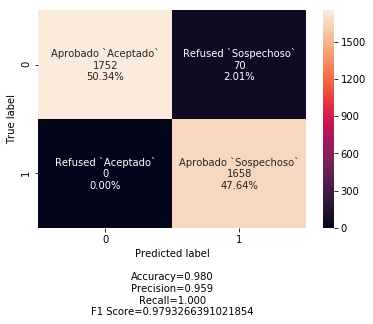

In [ ]:

from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['Aprobado `Aceptado`', 'Refused `Sospechoso`', 'Refused `Aceptado`', 'Aprobado `Sospechoso`']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
f1_score  = 2*precision*recall / (precision + recall)
sns.heatmap(cf_matrix, annot=labels, fmt='')
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={}".format(accuracy, precision, recall, f1_score)
plt.ylabel('True label')
plt.xlabel('Predicted label' + stats_text)

Text(0.5, 15.0, 'Predicted label\n\nAccuracy=0.992\nPrecision=0.866\nRecall=1.000\nF1 Score=0.9282296650717704')

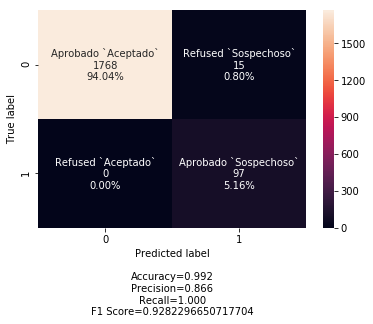

In [ ]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test2, y_pred2)
group_names = ['Aprobado `Aceptado`', 'Refused `Sospechoso`', 'Refused `Aceptado`', 'Aprobado `Sospechoso`']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
f1_score  = 2*precision*recall / (precision + recall)
sns.heatmap(cf_matrix, annot=labels, fmt='')
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={}".format(accuracy, precision, recall, f1_score)
plt.ylabel('True label')
plt.xlabel('Predicted label' + stats_text)

Text(0.5, 15.0, 'Predicted label\n\nAccuracy=0.958\nPrecision=1.000\nRecall=0.945\nF1 Score=0.9719564500164962')

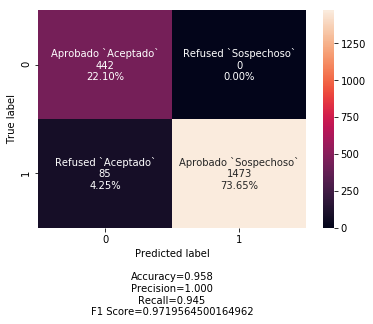

In [ ]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test3, y_pred3)
group_names = ['Aprobado `Aceptado`', 'Refused `Sospechoso`', 'Refused `Aceptado`', 'Aprobado `Sospechoso`']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
f1_score  = 2*precision*recall / (precision + recall)
sns.heatmap(cf_matrix, annot=labels, fmt='')
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={}".format(accuracy, precision, recall, f1_score)
plt.ylabel('True label')
plt.xlabel('Predicted label' + stats_text)

##### ¡ATENCIÓN! Su puntuación en este desafío de clasificación se basará en la puntuación F1 del modelo.

<hr>

### Construcción del Pipeline completo para el encapsulamiento en WML

In [ ]:
# Susbtituya el link de abajo por el link de su repositorio git (se es necesario)
!git clone https://github.com/vnderlev/sklearn_transforms.git

fatal: destination path 'sklearn_transforms' already exists and is not an empty directory.


In [ ]:
!cd sklearn_transforms
!ls -ltr

total 15264
-rw-r----- 1 dsxuser dsxuser 1751735 Sep  7 00:44 reto-4-compu-train.csv
-rw-r----- 1 dsxuser dsxuser 1751735 Sep  7 00:45 reto-4-compu-train.csv.1
drwxr-x--- 5 dsxuser dsxuser    4096 Sep  7 00:45 sklearn_transforms
-rw-r----- 1 dsxuser dsxuser  100124 Sep  7 00:46 to_be_scored_compusoluciones.csv
-rw-r----- 1 dsxuser dsxuser  100124 Sep  7 00:46 to_be_scored_compusoluciones.csv.1
-rw-r----- 1 dsxuser dsxuser  100124 Sep  7 00:47 to_be_scored_compusoluciones.csv.2
-rw-r----- 1 dsxuser dsxuser  100124 Sep  7 00:48 to_be_scored_compusoluciones.csv.3
-rw-r----- 1 dsxuser dsxuser  100124 Sep  7 00:48 to_be_scored_compusoluciones.csv.4
-rw-r----- 1 dsxuser dsxuser  100124 Sep  7 00:50 to_be_scored_compusoluciones.csv.5
-rw-r----- 1 dsxuser dsxuser  100124 Sep  7 00:50 to_be_scored_compusoluciones.csv.6
-rw-r----- 1 dsxuser dsxuser  100124 Sep  7 00:51 to_be_scored_compusoluciones.csv.7
-rw-r----- 1 dsxuser dsxuser 1751735 Sep  7 00:52 reto-4-compu-train.csv.2
-rw-r----- 1 dsxus

Para subir o código no WML, precisamos enviar um arquivo .zip com todo o código fonte, então iremos zipar o diretório clonado em seguida:

In [ ]:
!zip -r sklearn_transforms.zip sklearn_transforms

updating: sklearn_transforms/ (stored 0%)
updating: sklearn_transforms/my_custom_sklearn_transforms/ (stored 0%)
updating: sklearn_transforms/my_custom_sklearn_transforms/__init__.py (stored 0%)
updating: sklearn_transforms/my_custom_sklearn_transforms/sklearn_transformers.py (deflated 46%)
updating: sklearn_transforms/my_custom_sklearn_transforms.egg-info/ (stored 0%)
updating: sklearn_transforms/my_custom_sklearn_transforms.egg-info/SOURCES.txt (deflated 48%)
updating: sklearn_transforms/my_custom_sklearn_transforms.egg-info/not-zip-safe (stored 0%)
updating: sklearn_transforms/my_custom_sklearn_transforms.egg-info/top_level.txt (stored 0%)
updating: sklearn_transforms/my_custom_sklearn_transforms.egg-info/dependency_links.txt (stored 0%)
updating: sklearn_transforms/my_custom_sklearn_transforms.egg-info/PKG-INFO (deflated 33%)
updating: sklearn_transforms/setup.py (deflated 46%)
updating: sklearn_transforms/README.md (deflated 15%)
updating: sklearn_transforms/PKG-INFO (deflated 31%

Con el archivo zip de nuestro paquete cargado en el Kernel de este notebook, podemos utiliar la herramienta pip para instalarlo conforme a la siguiente celda:

In [ ]:
!pip install sklearn_transforms.zip

Processing ./sklearn_transforms.zip
  Stored in directory: /home/dsxuser/.tmp/pip-ephem-wheel-cache-fhoawnky/wheels/8f/88/32/f886e7510a37b111e2a1b7e689e04450acda46732970a7ed78
Successfully built my-custom-sklearn-transforms
  Found existing installation: my-custom-sklearn-transforms 1.0
    Uninstalling my-custom-sklearn-transforms-1.0:
      Successfully uninstalled my-custom-sklearn-transforms-1.0


Ahora podemos realizar la importación de nuestro paquiete personalizado en nuestro notabook!

Vamos a importan la transformación DropColumns. Si usted posee otras transformaciones personalizadas, ahora es que debe importarlas

In [ ]:
from my_custom_sklearn_transforms.sklearn_transformers import DropColumns

## Construyendo el model Pipeline

In [ ]:
from sklearn.utils import resample

dfAprobados=df[df.OBJETIVO=='Aceptado']
dfNoAprobados=df[df.OBJETIVO=='Sospechoso']

df_minority_upsampled=resample(dfNoAprobados, 
                                 replace=True,     # sample with replacement
                                 n_samples=8000 ,    # to match majority class
                                 ) # reproducible results
df_mayority_upsampled=resample(dfAprobados, 
                                 replace=True,     # sample with replacement
                                 n_samples=2000 ,    # to match majority class
                                 ) 
df=pd.concat([df, df_minority_upsampled])


# ATENCIÓN, NO CAMBIE LA CELDA DE ABAJO O SU MODELO NO SERA EVALUADO

In [ ]:
pipeline_input = df[
    [
        'EFECTIVO',
        'CXC',
        'INVENTARIO',
        'EQ_OFICINA',
        'EQ_TRANSPORTE',
        'TERRENOS_Y_CONSTRUCCIONES',
        'CXP',
        'CONTRIBUCIONES_X_PAGAR',
        'ANTICIPOS_CTE',
        'CAP_SOCIAL',
        'UTILIDADES_ACUMULADAS',
        'UTILIDAD_O_PERDIDA',
        'TOTAL_VENTAS',
        'TOTAL_COMPRAS',
        'UTILIDAD_BRUTA',
        'TOTAL_GASTOS',
    ]
]

pipeline_target = df['OBJETIVO']

In [ ]:
# Separación de los datos en un set de entrenamiento y otro de prueba (PARA CREACION DEL PIPELINE)
X_train, X_test, y_train, y_test = train_test_split(pipeline_input, pipeline_target, test_size=0.2, random_state=None)


### Borrando las columnas del dataset original

Debe elminiar todas las columnas que no esta usando

In [ ]:
# Creacion de la Transformación Personalizada ``DropColumns``

rm_columns = DropColumns(
    columns=[ 'CXC','EQ_OFICINA','EQ_TRANSPORTE' , 'CXP', 'CONTRIBUCIONES_X_PAGAR', 'CAP_SOCIAL' , 'TOTAL_COMPRAS', 'TOTAL_GASTOS'  ]
)

### Reemplazando con zeros en lugar de valores nulos

Ud puede usar otras estrategias, pero deben ser con Transforms

In [ ]:
# Crear un objeto ``SimpleImputer``
si = SimpleImputer(
    missing_values=np.nan,  # los valores que faltan son del tipo ``np.nan`` (Pandas estándar)
    strategy='mean',  # la estrategia elegida es cambiar el valor faltante por una constante
#     fill_value=0,  # la constante que se usará para completar los valores faltantes es un int64 = 0
    verbose=0,
    copy=True
)
so = SimpleImputer(
    missing_values=np.nan,  # los valores que faltan son del tipo ``np.nan`` (Pandas estándar)
    strategy='most_frequent',  # la estrategia elegida es cambiar el valor faltante por una constante
#     fill_value=0,  # la constante que se usará para completar los valores faltantes es un int64 = 0
    verbose=0,
    copy=True
)


### Estandarizando los valores numericos

In [ ]:
sc = MinMaxScaler()

### Pre-entrenando el modelo para definir el pipeline

En la celda de abajo se declara un objeto **Pipeline** de scikit-learn, donde es declarado como parametros *steps*, que es una lista de etapas a ejecutar el pipeline:

    'paso_1_remove_cols'     - Transformación personalizada DropColumns
    'paso_2_imputer'         - Transformación embebida de scikit-learn para remplazar los valores faltantes
    'paso_3_standard_scaler'          - Transformación embebida de scikit-learn para escalar las variables numéricas
    'su_modelo'              - Un árbol de desición simple
    
Note que pasamos como pasos las transformaciones instanciadas anteriormente, con nombres `rm_columns` y `si`.

In [ ]:
# Creación de nuestro para almacenamiento en Watson Machine Learning:
my_pipeline = Pipeline(
    steps=[
        ('paso_1_remove_cols', rm_columns),
        ('paso_2_imputer', si),
        ('paso_3_standard_scaler', sc),
        ('su_modelo', KNeighborsClassifier(n_neighbors=1)),
    ]
)

En seguida ejecutaremos el método `fit()` del Pipeline, realizando el pré-procesamiento y el entrenamiento del modelo de una sola vez.

In [ ]:
# Inicializando el Pipeline (pre-procesamiento y entrenamiento del modelo)
my_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('paso_1_remove_cols', DropColumns(columns=['CXC', 'EQ_OFICINA', 'EQ_TRANSPORTE', 'CXP', 'CONTRIBUCIONES_X_PAGAR', 'CAP_SOCIAL', 'TOTAL_COMPRAS', 'TOTAL_GASTOS'])), ('paso_2_imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
       verbose=0)), ('paso_3_s...ki',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform'))])

Text(0.5, 15.0, 'Predicted label\n\nAccuracy=0.984\nPrecision=0.968\nRecall=1.000\nF1 Score=0.984')

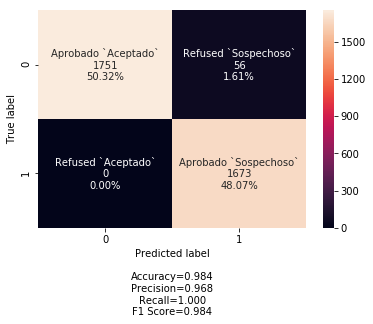

In [ ]:
### Haciendo una predicción con el set de prueba

y_pred = my_pipeline.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['Aprobado `Aceptado`', 'Refused `Sospechoso`', 'Refused `Aceptado`', 'Aprobado `Sospechoso`']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
f1_score  = 2*precision*recall / (precision + recall)
sns.heatmap(cf_matrix, annot=labels, fmt='')
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(accuracy, precision, recall, f1_score)
plt.ylabel('True label')
plt.xlabel('Predicted label' + stats_text)

In [ ]:
# Precisión simple
my_pipeline.score(X_test, y_test)
# El desafio luego se cambio y se hizo sin pipeline pero lo dejo aqui porque me interesa tener com hacer una pipeline 

0.9839080459770115

<hr>

In [ ]:
!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/vanderlei-test/dataset/master/to_be_scored_compusoluciones.csv
df_to_be_scored = pd.read_csv(r'to_be_scored_compusoluciones.csv')
df_to_be_scored.tail()
df_to_be_scored=df_to_be_scored[[
        
       
        'EFECTIVO',
        'INVENTARIO',
        'TERRENOS_Y_CONSTRUCCIONES',
        'ANTICIPOS_CTE',
        'UTILIDADES_ACUMULADAS',
        'UTILIDAD_O_PERDIDA',
        'TOTAL_VENTAS',
        'UTILIDAD_BRUTA',
    ]]

si.fit(X=df_to_be_scored[
    [
        
       
        'EFECTIVO',
        'INVENTARIO',
        'TERRENOS_Y_CONSTRUCCIONES',
        'ANTICIPOS_CTE',
        'UTILIDADES_ACUMULADAS',
        'UTILIDAD_O_PERDIDA',
        'TOTAL_VENTAS',
        'UTILIDAD_BRUTA',
    ]
])
df_to_be_scored = pd.DataFrame.from_records(
    data=si.transform(df_to_be_scored),  # el resultado SimpleImputer.transform (<< pandas dataframe >>) es lista lista
    columns=[
        'EFECTIVO',
        'INVENTARIO',
        'TERRENOS_Y_CONSTRUCCIONES',
        'ANTICIPOS_CTE',
        'UTILIDADES_ACUMULADAS',
        'UTILIDAD_O_PERDIDA',
        'TOTAL_VENTAS',
        'UTILIDAD_BRUTA',
    ] # las columnas originales deben conservarse en esta transformación
)
df_to_be_scored[[
        'EFECTIVO',
        'INVENTARIO',
        'TERRENOS_Y_CONSTRUCCIONES',
        'ANTICIPOS_CTE',
        'UTILIDADES_ACUMULADAS',
        'UTILIDAD_O_PERDIDA',
        'TOTAL_VENTAS',
        'UTILIDAD_BRUTA',
    ]]  = pd.DataFrame.from_records(
    data=sc.transform(df_to_be_scored),  # el resultado SimpleImputer.transform (<< pandas dataframe >>) es lista lista
    columns=[
        'EFECTIVO',
        'INVENTARIO',
        'TERRENOS_Y_CONSTRUCCIONES',
        'ANTICIPOS_CTE',
        'UTILIDADES_ACUMULADAS',
        'UTILIDAD_O_PERDIDA',
        'TOTAL_VENTAS',
        'UTILIDAD_BRUTA',
    ] # las columnas originales deben conservarse en esta transformación
)

--2020-09-07 01:05:42--  https://raw.githubusercontent.com/vanderlei-test/dataset/master/to_be_scored_compusoluciones.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100124 (98K) [text/plain]
Saving to: ‘to_be_scored_compusoluciones.csv.15’

100%[======================================>] 100,124     --.-K/s   in 0.006s  

2020-09-07 01:05:42 (16.9 MB/s) - ‘to_be_scored_compusoluciones.csv.15’ saved [100124/100124]



In [ ]:
y_pred = dtc.predict(df_to_be_scored)


In [ ]:
df_to_be_scored

,EFECTIVO,INVENTARIO,TERRENOS_Y_CONSTRUCCIONES,ANTICIPOS_CTE,UTILIDADES_ACUMULADAS,UTILIDAD_O_PERDIDA,TOTAL_VENTAS,UTILIDAD_BRUTA
0,0.004188,0.105622,0.678475,0.135660,0.621764,0.379020,0.081200,0.141164
1,0.000546,0.218752,0.565488,0.056003,0.585613,0.247248,0.170109,0.131817
2,0.024085,0.046406,0.153363,0.479139,0.585486,0.280454,0.092793,0.185422
3,0.000287,0.023980,0.849822,0.028729,0.589765,0.423399,0.092793,0.068784
4,0.005209,0.220052,0.565488,0.186323,0.579739,0.858349,0.295057,0.105275
5,0.005209,0.000117,0.565488,0.091019,0.417577,0.504755,0.002634,0.105275
6,0.000868,0.034212,0.713291,0.004623,0.585486,0.701438,0.062692,0.067418
7,0.001251,0.079043,0.901479,0.085089,0.410314,0.831520,0.082622,0.173572
8,0.000343,0.006579,0.860135,0.102226,0.401160,0.550912,0.001302,0.105275
9,0.000565,0.080538,0.929535,0.000708,0.431210,0.550912,0.064688,0.282762


In [ ]:
df_to_be_scored['target'] = y_pred
df_to_be_scored.tail()
project.save_data(file_name="results.csv", data=df_to_be_scored.to_csv(index=False))

{'file_name': 'results.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'bcdesafio4-donotdelete-pr-bv1tljj38nh9dv',
 'asset_id': '59ae9e72-bae6-4880-8924-caa8e945dd96'}

<hr>

## ¡Felicitaciones! 

Si todo fue ejecutado sin errores, ¡usted ya tiene un predictor basado en clasificacíon binaria encapsulado como una API REST!

Para enviar su solución, accede a la página:

# https://compusoluciones.maratona.dev

Usted necesitará del endpoint url de su modelo y las credenciales de WML :)